### Diccionario  de Datos
Características de entrada en orden:

1. CRIM: tasa de criminalidad per cápita por ciudad
2. ZN: proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados
3. INDUS: proporción de acres de negocios no minoristas por ciudad
4.  CHAS: variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)
5.  NOX: concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M]
6.  RM: número promedio de habitaciones por vivienda
7.  AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8.  DIS: distancias ponderadas a cinco centros de empleo de Boston
9.  RAD: índice de accesibilidad a las autopistas radiales
10- TAX: tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]
11.  PTRATIO: proporción alumno-maestro por ciudad
12.  B: El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
13.  LSTAT: % de población de menor estatus socioeconómico

### Variable de salida:

14.  MEDV: Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$]


# Preparacion del entorno de Trabajo

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, HuberRegressor, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, mean_absolute_percentage_error
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler


In [227]:
df_precios_casas = pd.read_csv("house-prices-tp.csv")
df_original = df_precios_casas.copy()

# Train-Test
Decidimos hacer la division del dataset antes de comenzar el analisis y hacer cualquier tratado de datos ya que necesitamos que el dataset de testeo sea tomado como datos desconocidos

In [228]:
X_train, X_test, y_train, y_test = train_test_split(df_precios_casas.drop(columns=['MEDV']), df_precios_casas['MEDV'], test_size=0.2, random_state=42)

df_entrenamiento = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

# Análisis Exploratorio

## Limpieza de Datos

### Verificamos valores nulos

In [229]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       19
ZN         18
INDUS      12
CHAS       20
NOX        21
RM         17
AGE        22
DIS        14
RAD        26
TAX        13
PTRATIO    22
B          18
LSTAT      18
MEDV       19
dtype: int64

Como primera medida eliminaremos las fila que tengan la variable de salida nula o mas de 11 columnas nulas ya que las consideramos irrelevantes para el analisis

In [230]:
filas_nan = []

for index, row in df_entrenamiento.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_entrenamiento.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")


Filas eliminadas: 19


In [231]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM        7
ZN          8
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         4
RAD        10
TAX         5
PTRATIO     5
B           6
LSTAT       6
MEDV        0
dtype: int64

Imputaremos la columna binaria con la moda

In [232]:
df_entrenamiento['CHAS'] = df_entrenamiento['CHAS'].fillna(df_entrenamiento['CHAS'].mode()[0])

Y el resto de columnas seran inputadas con KNN

In [233]:
imputer = KNNImputer(n_neighbors=5)

df_entrenamiento = pd.DataFrame(imputer.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)


In [234]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Exploracion de outliers

C:\Users\franco\AppData\Local\Temp\ipykernel_6416\490921543.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_entrenamiento, x='CHAS', palette="viridis")


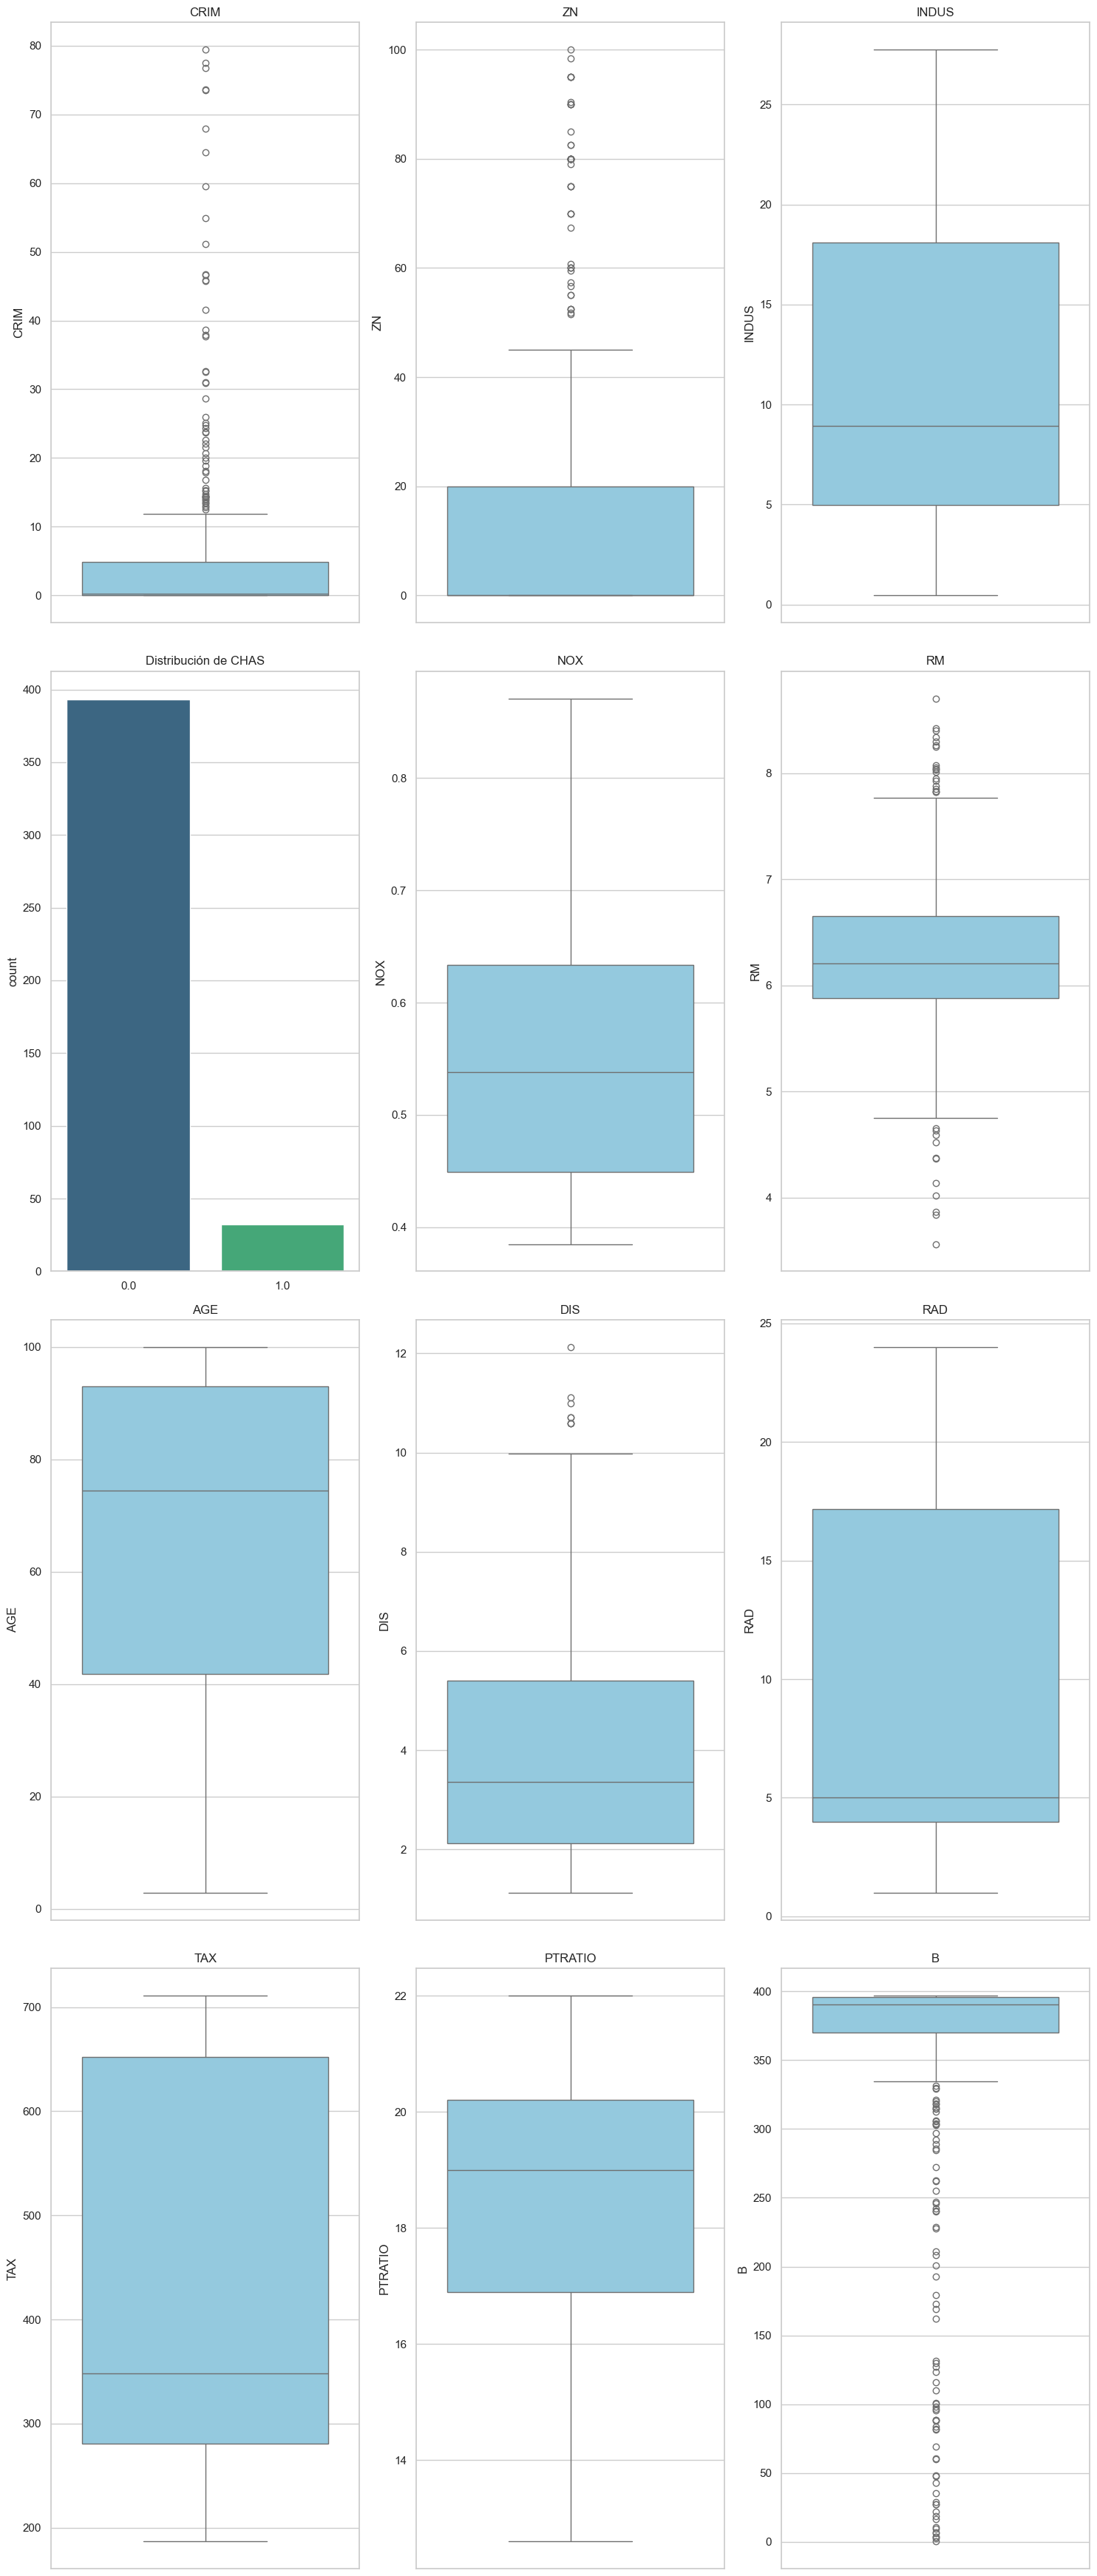

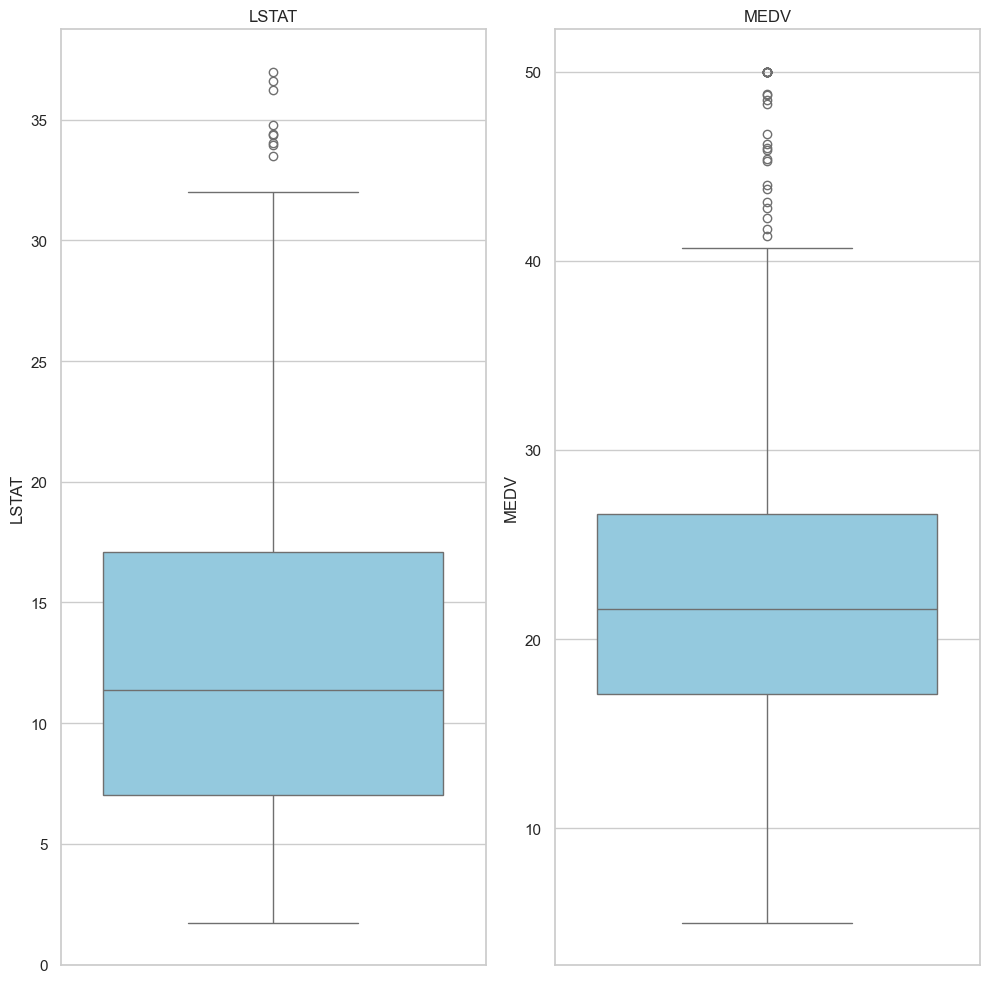

In [235]:
sns.set_theme(style="whitegrid")

num_columns = len(df_entrenamiento.columns)

max_plots_per_figure = 12
num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure

for fig_index in range(num_figures):
    start_index = fig_index * max_plots_per_figure
    end_index = min(start_index + max_plots_per_figure, num_columns)

    plt.figure(figsize=(15, 5 * ((end_index - start_index + 2) // 2)))

    for i, column in enumerate(df_entrenamiento.columns[start_index:end_index]):
        plt.subplot((end_index - start_index + 2) // 3, 3, i + 1)
        if column == 'CHAS':
            sns.countplot(data=df_entrenamiento, x='CHAS', palette="viridis")
            plt.title('Distribución de CHAS')
        else:
            sns.boxplot(data=df_entrenamiento[column], color="skyblue")
            plt.title(column)
        plt.xlabel('')

    plt.tight_layout()

    plt.show()

Podemos notar varias variables con presencia de outliers por lo cual deberiamos hacer un analisis mas profundo

In [236]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: CRIM - Porcentaje de valores atípicos: 13.18%
Columna: ZN - Porcentaje de valores atípicos: 11.76%
Columna: INDUS - Porcentaje de valores atípicos: 0.00%
Columna: CHAS - Porcentaje de valores atípicos: 7.53%
Columna: NOX - Porcentaje de valores atípicos: 0.00%
Columna: RM - Porcentaje de valores atípicos: 7.06%
Columna: AGE - Porcentaje de valores atípicos: 0.00%
Columna: DIS - Porcentaje de valores atípicos: 1.88%
Columna: RAD - Porcentaje de valores atípicos: 0.00%
Columna: TAX - Porcentaje de valores atípicos: 0.00%
Columna: PTRATIO - Porcentaje de valores atípicos: 0.00%
Columna: B - Porcentaje de valores atípicos: 18.35%
Columna: LSTAT - Porcentaje de valores atípicos: 2.12%
Columna: MEDV - Porcentaje de valores atípicos: 6.82%


## Analisis Descriptivo

<Figure size 1500x1500 with 0 Axes>

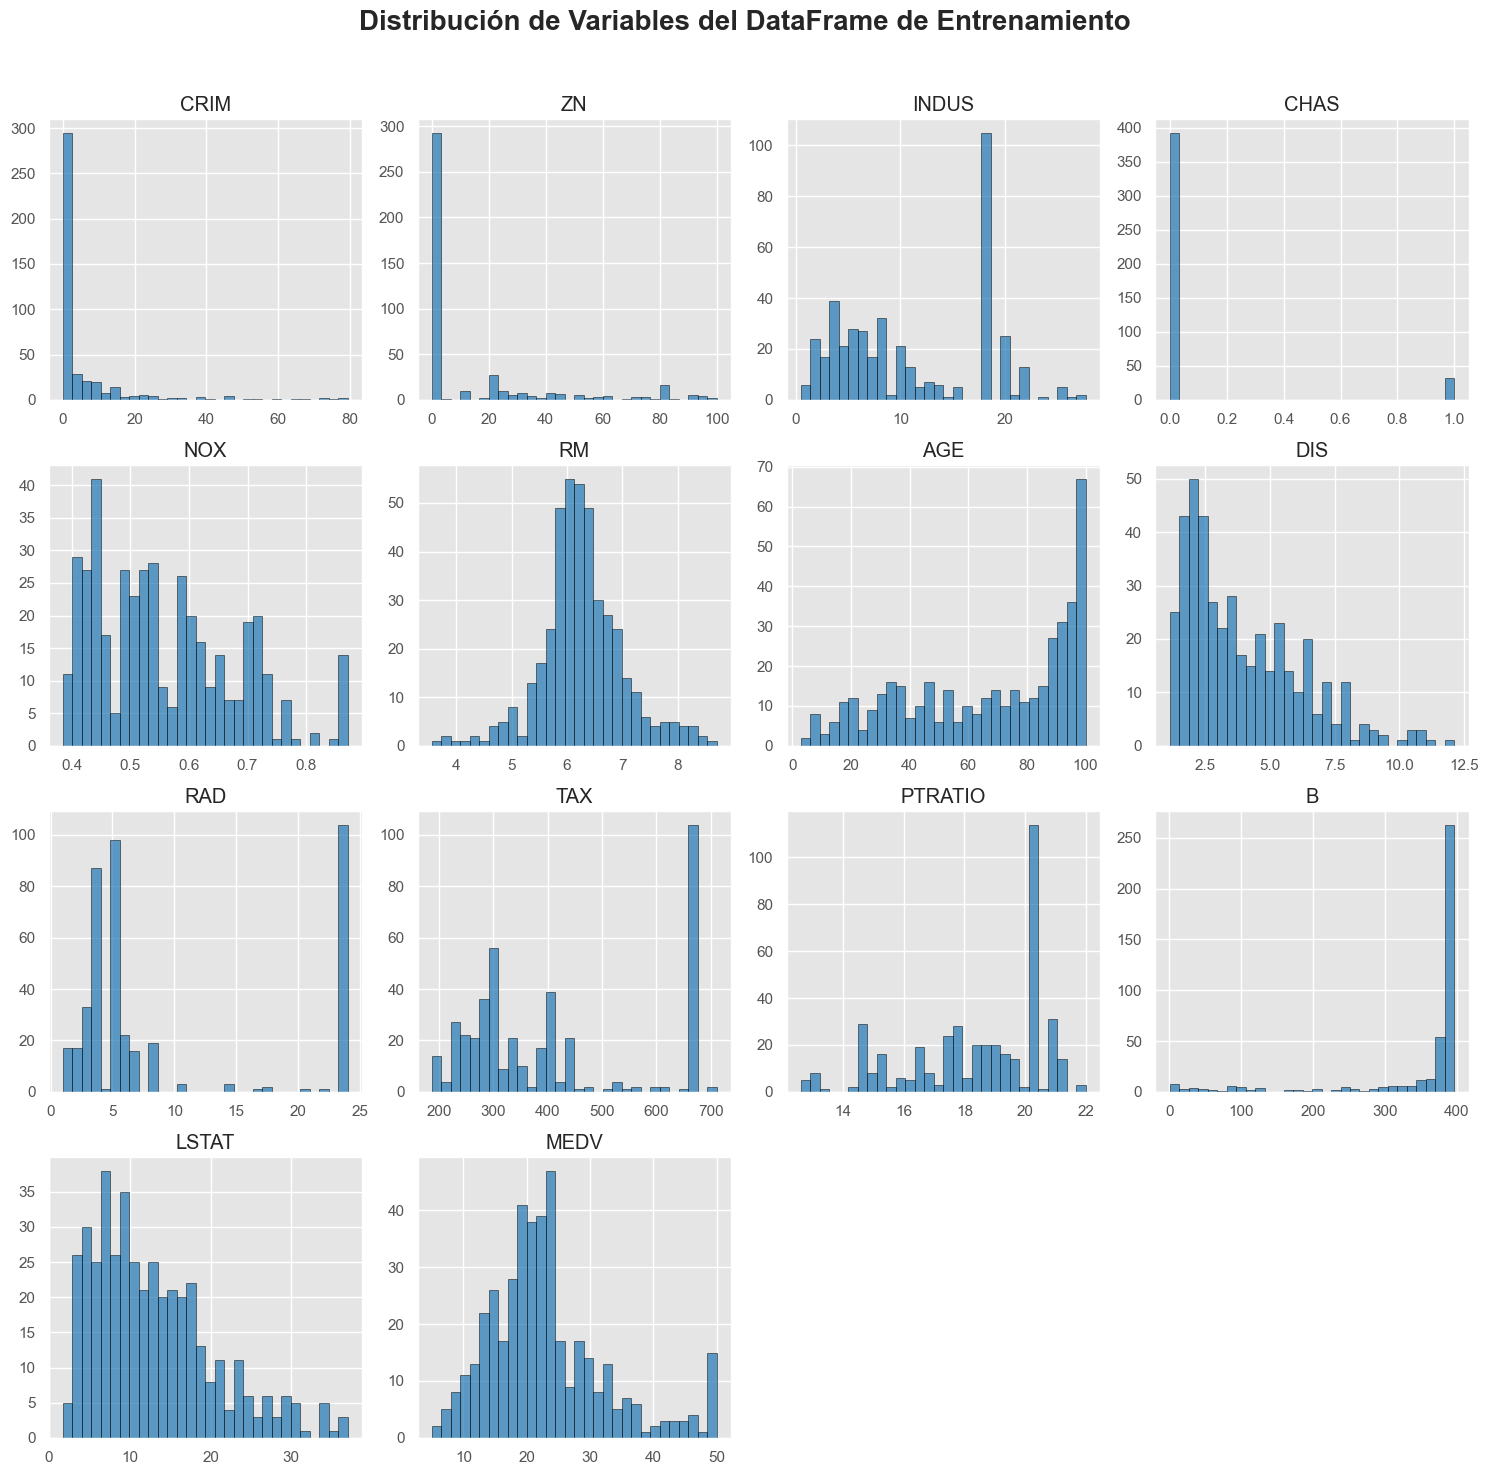

In [237]:

plt.figure(figsize=(15, 15))

plt.style.use('ggplot')

df_entrenamiento.hist(bins=30, color='#1f77b4', edgecolor='black', alpha=0.7, figsize=(15, 15))

plt.suptitle('Distribución de Variables del DataFrame de Entrenamiento', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [238]:
df_entrenamiento.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,5.529209,13.888083,11.015116,0.075294,0.557949,6.268923,66.761486,3.956498,9.536218,410.502761,18.386908,347.243733,12.884819,22.929072
std,12.686008,25.441893,6.832557,0.264176,0.119567,0.742067,28.693630,2.229679,8.551540,165.365812,2.216476,99.270150,7.504014,9.406067
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.079780,0.000000,4.987915,0.000000,0.449000,5.880000,41.839732,2.124700,4.000000,281.000000,16.900000,370.220000,7.033962,17.100000
50%,0.269380,0.000000,8.937346,0.000000,0.538000,6.209000,74.400000,3.363300,5.000000,348.000000,19.000000,390.550000,11.380000,21.600000
75%,4.835670,20.000000,18.100000,0.000000,0.633879,6.649000,93.000000,5.400700,17.164570,652.148598,20.200000,395.990000,17.100000,26.600000
max,79.412097,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000,50.000000


In [239]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     425 non-null    float64
 1   ZN       425 non-null    float64
 2   INDUS    425 non-null    float64
 3   CHAS     425 non-null    float64
 4   NOX      425 non-null    float64
 5   RM       425 non-null    float64
 6   AGE      425 non-null    float64
 7   DIS      425 non-null    float64
 8   RAD      425 non-null    float64
 9   TAX      425 non-null    float64
 10  PTRATIO  425 non-null    float64
 11  B        425 non-null    float64
 12  LSTAT    425 non-null    float64
 13  MEDV     425 non-null    float64
dtypes: float64(14)
memory usage: 46.6 KB


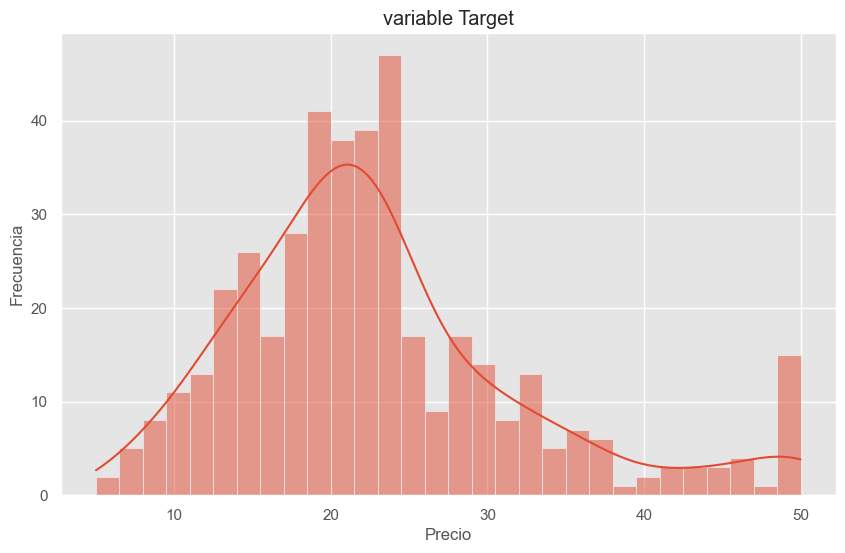

In [240]:
plt.figure(figsize=(10, 6))
sns.histplot(df_entrenamiento['MEDV'], bins=30, kde=True)
plt.title('variable Target')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now depr

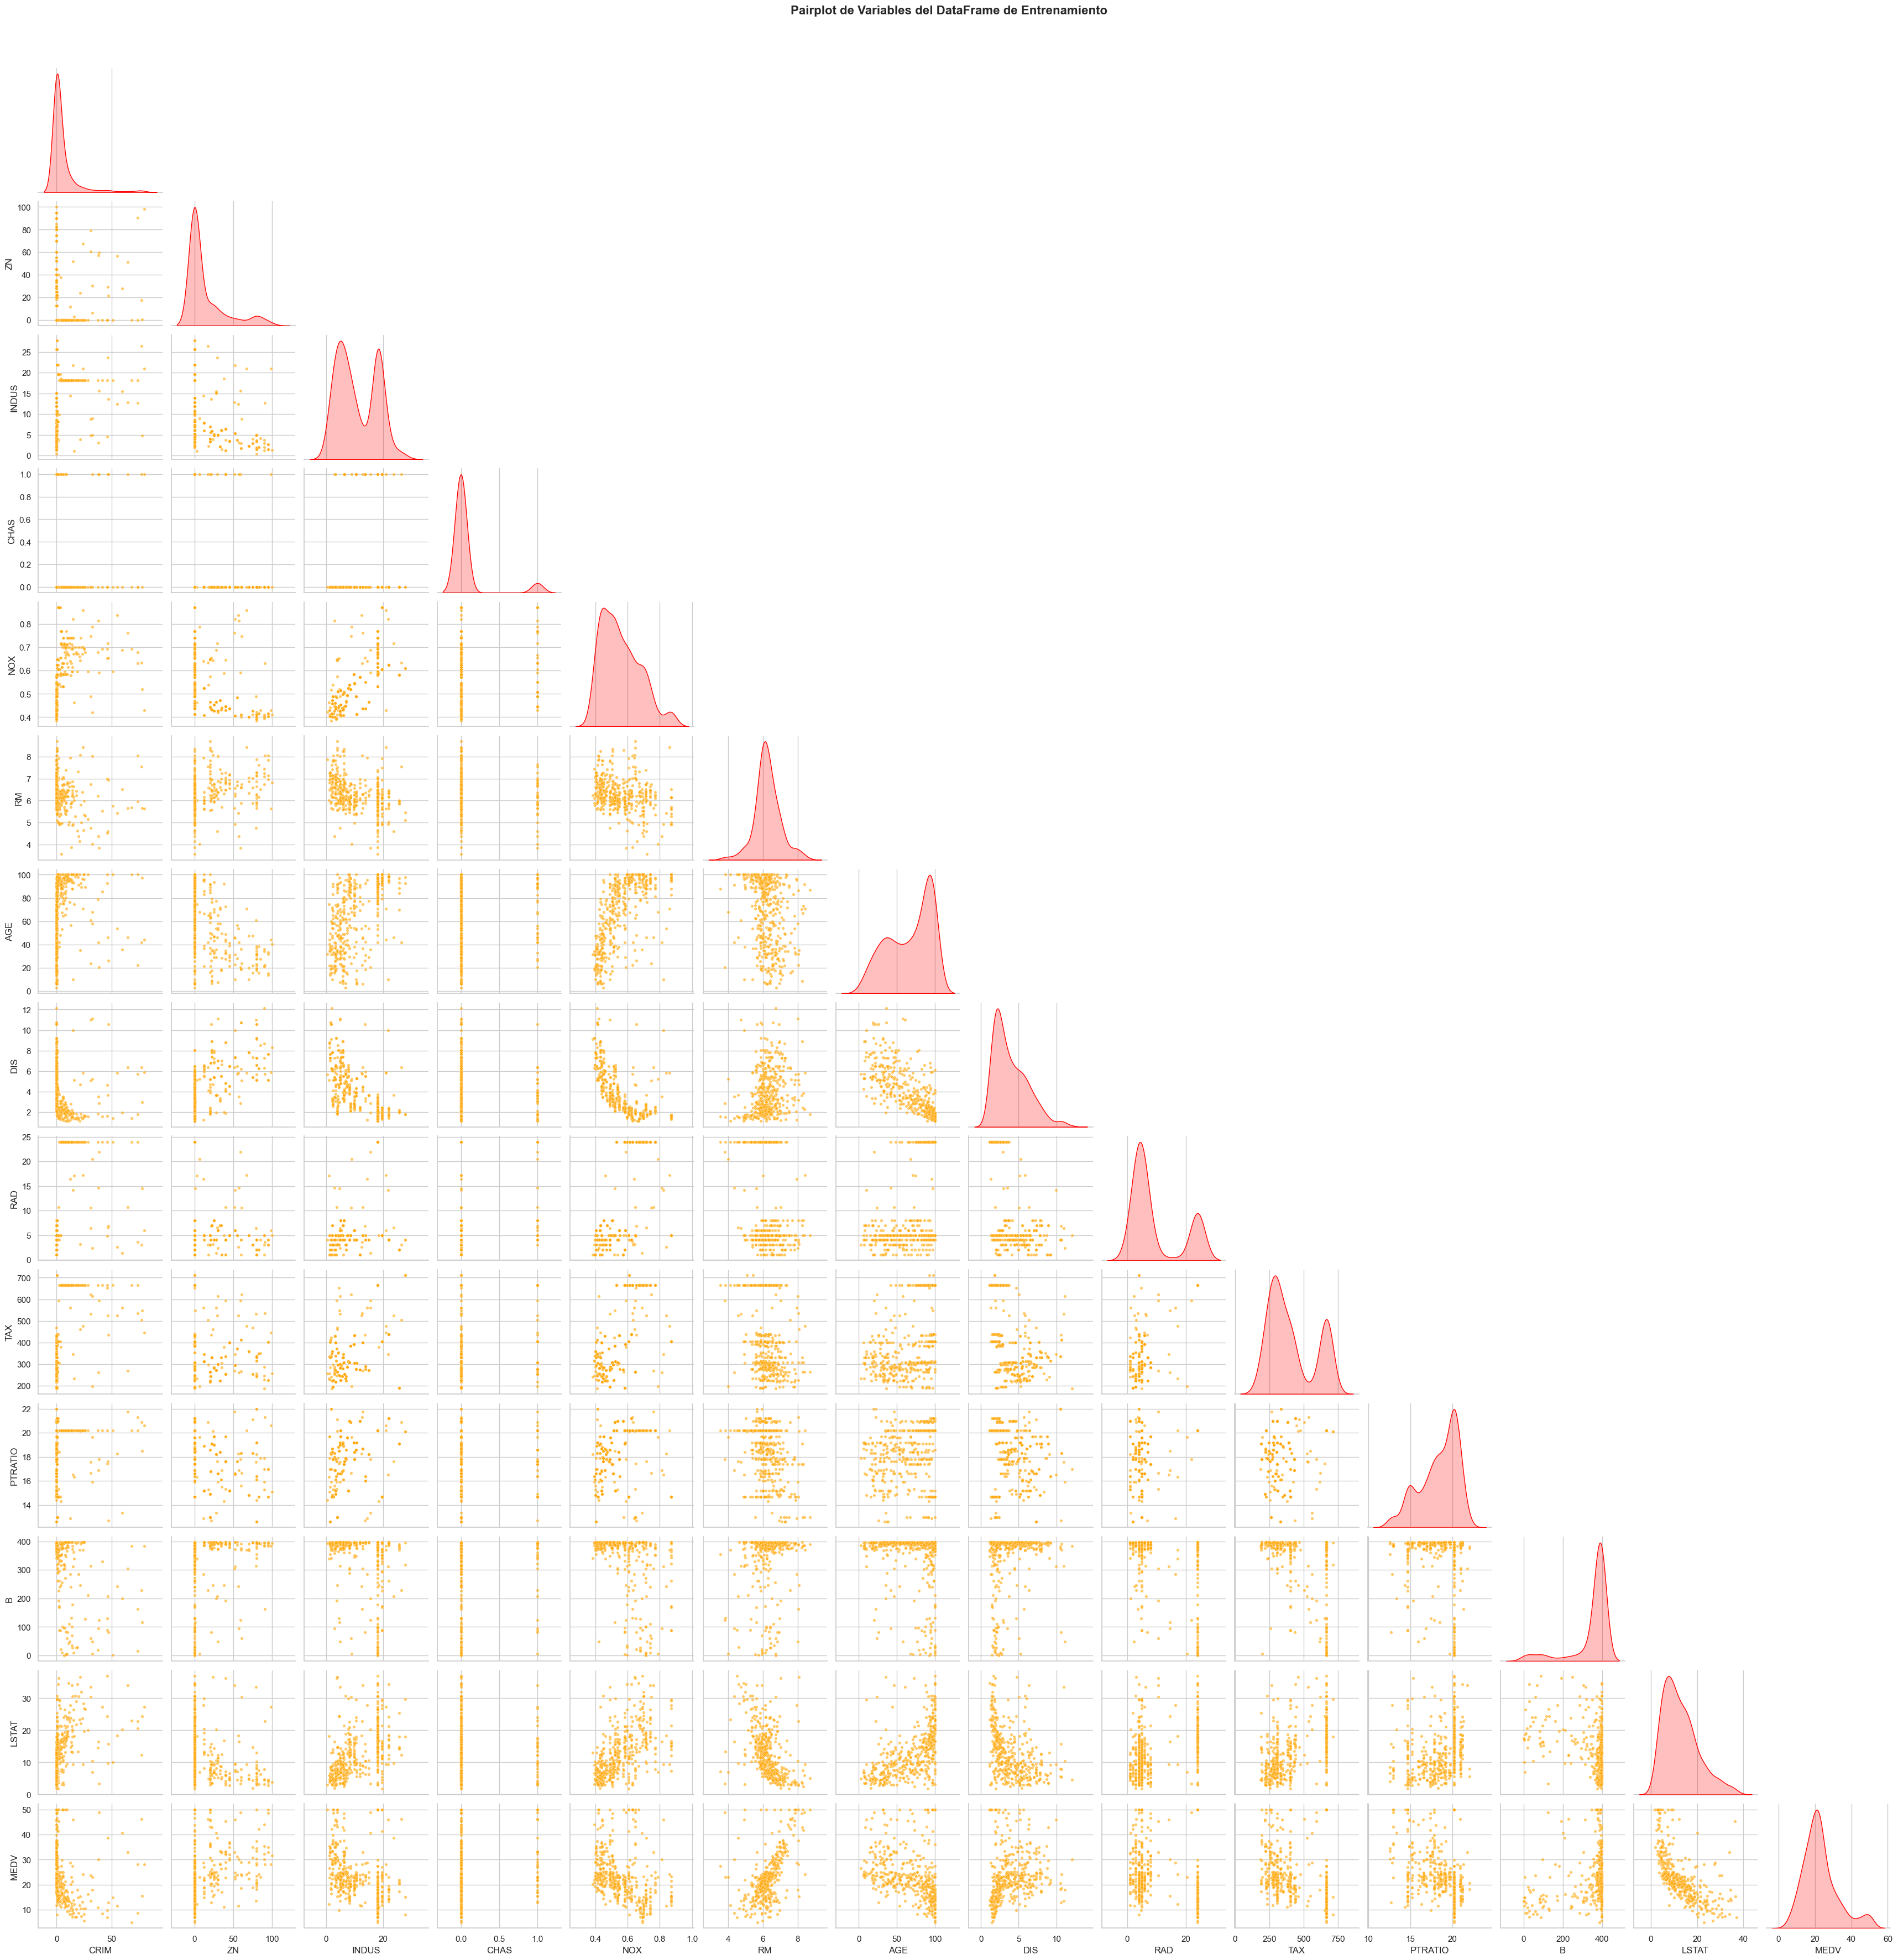

In [241]:
sns.set_theme(style="whitegrid")

sns.pairplot(
    df_entrenamiento,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 'color': 'orange', 's': 15},
    diag_kws={'color': 'red', 'shade': True},
    height=2.5,
    aspect=1,
    corner=True,
)

plt.suptitle('Pairplot de Variables del DataFrame de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)

plt.show()

#### Matriz de correlación

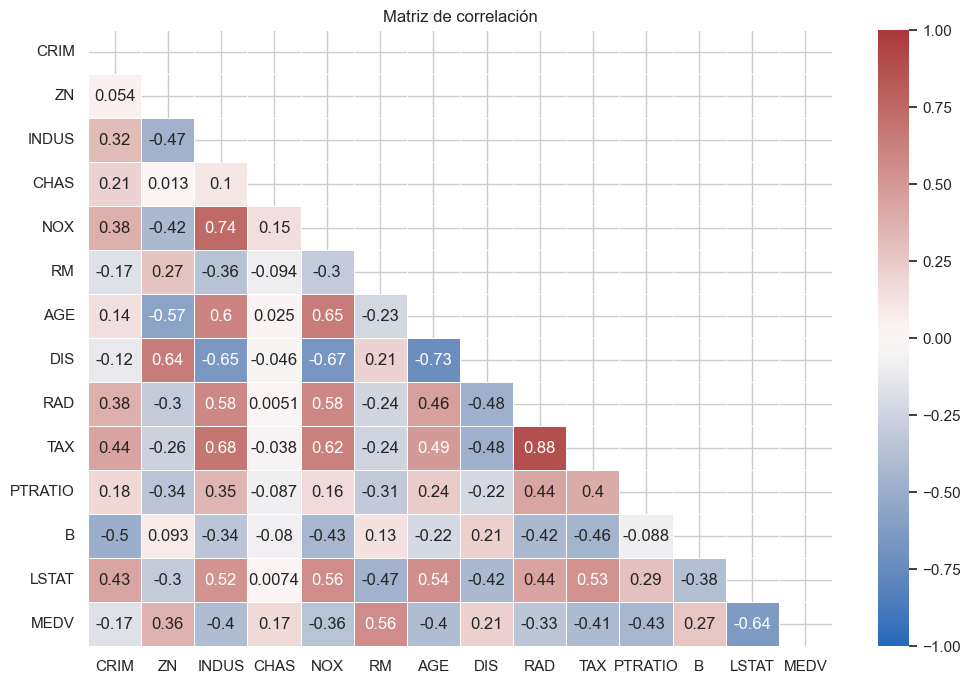

In [242]:
corr_matrix = df_entrenamiento.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Notamos una fuerte relacion entre las variables TAX y RAD (0.88) y NOX e INDUS (0.74) por lo cual creemos pertinente revisarlo

# Valores nulos en dataset de testeo

In [243]:
df_test.isnull().sum()

CRIM       4
ZN         4
INDUS      3
CHAS       3
NOX        3
RM         4
AGE        2
DIS        1
RAD        2
TAX        5
PTRATIO    6
B          4
LSTAT      4
MEDV       2
dtype: int64

Usamos el mismo criterio que en el dataset de entrenamiento para eliminar filas completas

In [244]:
filas_nan = []

for index, row in df_test.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_test.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")

Filas eliminadas: 2


Aqui repetimos el criterio de rellenar con la moda que en el caso del entrenamiento fue de `0`

In [245]:
df_test['CHAS'] = df_test['CHAS'].fillna(0)

In [246]:
df_test.isnull().sum()

CRIM       4
ZN         3
INDUS      3
CHAS       0
NOX        2
RM         2
AGE        2
DIS        1
RAD        2
TAX        4
PTRATIO    4
B          3
LSTAT      3
MEDV       0
dtype: int64

Y por ultimo usamos el mismo `imputer` para rellenar los restantes

In [247]:
df_test = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

In [248]:
df_test.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Escalamiento de datos

In [249]:
X_train = df_entrenamiento.drop(columns=['MEDV'])  # Todas las columnas excepto 'MEDV'
y_train = df_entrenamiento['MEDV']  # Solo la columna 'MEDV'

X_test = df_test.drop(columns=['MEDV'])  # Todas las columnas excepto 'MEDV'
y_test = df_test['MEDV']  # Solo la columna 'MEDV'

In [250]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Obtención de las métricas

In [251]:
regresiones_lineales = {
    "Linear Regression": LinearRegression(),
    "SGD Regression": SGDRegressor(max_iter=1000, tol=1e-3),
    "Lasso": LassoCV(cv=5, random_state=42),
    "Ridge": RidgeCV(cv=5, alphas=np.logspace(-6, 6, 13)),
    "ElasticNet": ElasticNetCV(cv=5, random_state=42)
}

resultados = pd.DataFrame()

for name, regressor in regresiones_lineales.items():
    # Entrenar el modelo
    regressor.fit(X_train_scaled, y_train)

    # Predicciones
    y_train_pred = regressor.predict(X_train_scaled)
    y_test_pred = regressor.predict(X_test_scaled)

    # Calcular métricas
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    # Guardar resultados
    resultado = pd.DataFrame({
        "Regresión lineal": [name],
        "Train RMSE": [train_rmse],
        "Test RMSE": [test_rmse],
        "Train R2": [train_r2],
        "Test R2": [test_r2],
        "Train MSE": [train_mse],
        "Test MSE": [test_mse],
        "Train MAE": [train_mae],
        "Test MAE": [test_mae],
        "Train MAPE": [train_mape],
        "Test MAPE": [test_mape]
    })
    resultados = pd.concat([resultados, resultado], ignore_index=True)

print(resultados)


    Regresión lineal  Train RMSE  Test RMSE  Train R2   Test R2  Train MSE  \
0  Linear Regression    5.663325   6.360105  0.636629  0.577240  32.073245   
1     SGD Regression    5.667685   6.418812  0.636070  0.569399  32.122648   
2              Lasso    5.665204   6.333995  0.636388  0.580704  32.094536   
3              Ridge    5.668367   6.307429  0.635982  0.584214  32.130385   
4         ElasticNet    5.694314   6.234733  0.632642  0.593743  32.425207   

    Test MSE  Train MAE  Test MAE  Train MAPE  Test MAPE  
0  40.450941   3.811888  4.202835    0.190439   0.233173  
1  41.201153   3.813153  4.240463    0.190448   0.235568  
2  40.119486   3.808287  4.193769    0.189780   0.232137  
3  39.783657   3.801861  4.178691    0.189084   0.231150  
4  38.871893   3.811353  4.152863    0.188313   0.228831  


c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWa

## Comparación de Modelos

### Linear Regression

- **Train RMSE:** 5.66
- **Test RMSE:** 6.36
- **Train R²:** 0.637
- **Test R²:** 0.577
- **Train MSE:** 32.07
- **Test MSE:** 40.45
- **Train MAE:** 3.81
- **Test MAE:** 4.20
- **Train MAPE:** 19.04%
- **Test MAPE:** 23.32%

El modelo de regresión lineal tiene un ajuste razonablemente bueno en los datos de entrenamiento, pero en los datos de prueba su desempeño es un poco más débil. El Test R² sugiere que el modelo no explica tanto la variabilidad en los datos de prueba en comparación con los de entrenamiento. Sin embargo, los errores de predicción (RMSE, MSE y MAE) no son excesivamente grandes, lo que indica un rendimiento aceptable.

### SGD Regression

- **Train RMSE:** 5.67
- **Test RMSE:** 6.40
- **Train R²:** 0.636
- **Test R²:** 0.572
- **Train MSE:** 32.11
- **Test MSE:** 40.99
- **Train MAE:** 3.82
- **Test MAE:** 4.24
- **Train MAPE:** 19.11%
- **Test MAPE:** 23.57%

El modelo de regresión mediante SGD tiene un rendimiento casi idéntico al de la regresión lineal básica, con una ligera desventaja en el Test RMSE y Test R². La diferencia es mínima, pero sugiere que la implementación mediante SGD no aporta mejoras sustanciales en este caso.

### Lasso

- **Train RMSE:** 5.67
- **Test RMSE:** 6.33
- **Train R²:** 0.636
- **Test R²:** 0.581
- **Train MSE:** 32.09
- **Test MSE:** 40.12
- **Train MAE:** 3.81
- **Test MAE:** 4.19
- **Train MAPE:** 18.98%
- **Test MAPE:** 23.21%

El modelo Lasso ofrece un rendimiento ligeramente mejor en los datos de prueba en comparación con la regresión lineal y SGD, con un menor Test RMSE y un Test R² más alto. Esto sugiere que la regularización aplicada por Lasso ayuda a controlar el sobreajuste, mejorando la capacidad de generalización del modelo.

### Ridge

- **Train RMSE:** 5.67
- **Test RMSE:** 6.31
- **Train R²:** 0.636
- **Test R²:** 0.584
- **Train MSE:** 32.13
- **Test MSE:** 39.78
- **Train MAE:** 3.80
- **Test MAE:** 4.18
- **Train MAPE:** 18.91%
- **Test MAPE:** 23.12%

El modelo Ridge también tiene un rendimiento superior en los datos de prueba en comparación con la regresión lineal básica, con una mejora leve en el Test RMSE y el Test R². La regularización de Ridge parece ser efectiva para mejorar la precisión de predicción del modelo.

### ElasticNet

- **Train RMSE:** 5.69
- **Test RMSE:** 6.23
- **Train R²:** 0.633
- **Test R²:** 0.594
- **Train MSE:** 32.43
- **Test MSE:** 38.87
- **Train MAE:** 3.81
- **Test MAE:** 4.15
- **Train MAPE:** 18.83%
- **Test MAPE:** 22.88%

ElasticNet muestra el mejor rendimiento en términos de Test RMSE y Test R², superando tanto a Ridge como a Lasso. Esto sugiere que el modelo es el más efectivo en términos de generalización en este conjunto de datos, manejando tanto la regularización L1 como L2 de manera adecuada.


# Implementación de Modelos de Regresión

Coeficientes del modelo de regresión lineal:
[ 1.170809    1.76108583 -0.05982536  1.44421422 -0.564668    2.78491169
 -1.40697326 -3.23235834  1.47784812 -1.83300492 -1.65364038  1.00046156
 -3.74580781]
0.6366293547671567

Coeficientes del modelo Lasso:
[ 0.89222444  1.56659141 -0.10580217  1.4167326  -0.25708952  2.73778563
 -1.2071522  -2.68819584  0.5681335  -0.98727496 -1.49158046  0.82779883
 -3.7972617 ]
0.632559157210947

Coeficientes del modelo Ridge:
[ 1.1697858   1.75976481 -0.06080191  1.44431737 -0.56381792  2.78461843
 -1.40613948 -3.22958381  1.47450682 -1.82921675 -1.65330325  1.00016443
 -3.74503686]
0.6366292738882728

Coeficientes del modelo ElasticNet:
[ 1.13576542  1.7244089  -0.08129429  1.44452544 -0.53218385  2.77638083
 -1.3796202  -3.14758969  1.36636098 -1.71616565 -1.63873827  0.9855932
 -3.7315506 ]
0.6365518741272238


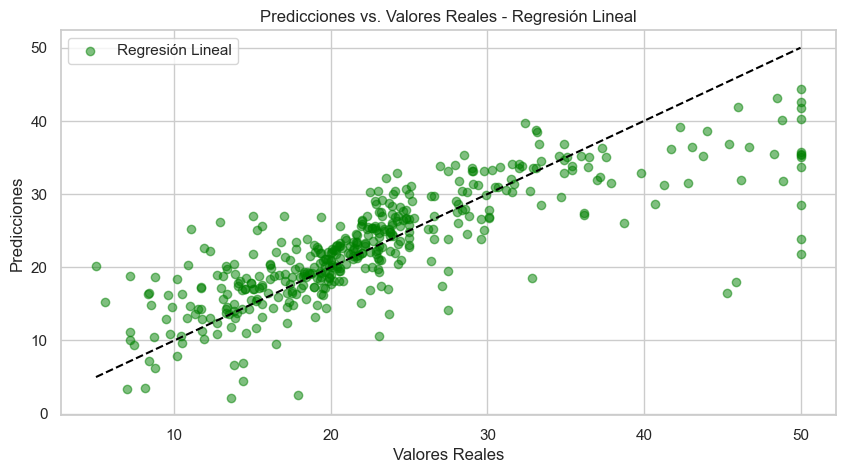

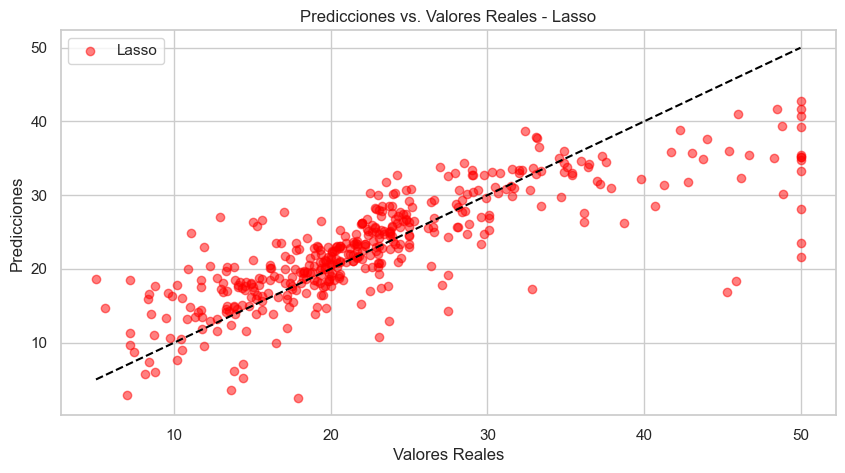

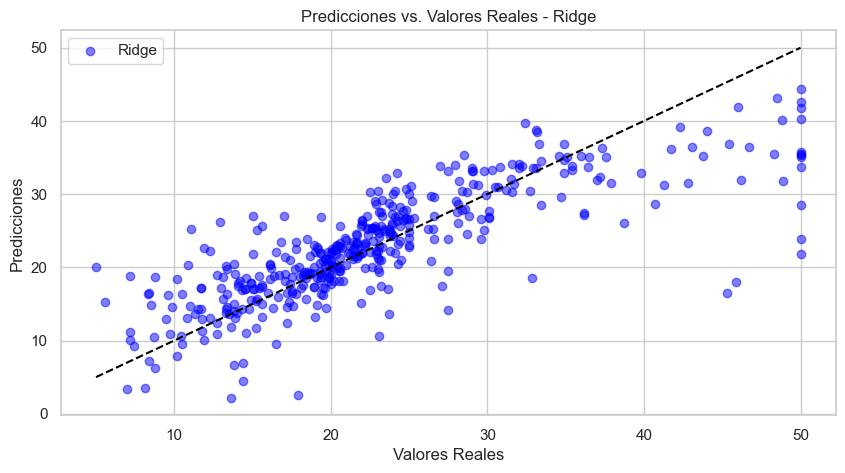

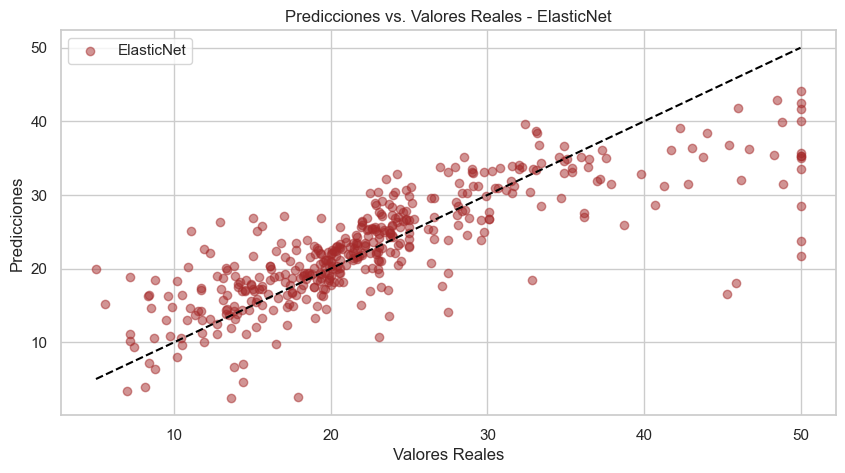

In [252]:

# Crear modelos de regresión lineal, Lasso y Ridge
lr = LinearRegression()
lasso = Lasso(alpha=0.1)  # alpha controla la fuerza de la regularización L1 (Lasso)
ridge = Ridge(alpha=0.1)  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)

# Inicializar modelos con los mismos datos
lr.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
elasticnet.fit(X_train_scaled, y_train)

# Mostrar coeficientes
print("Coeficientes del modelo de regresión lineal:")
print(lr.coef_)
print(lr.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print(lasso.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print(ridge.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print(elasticnet.score(X_train_scaled, y_train))

# Gráfico para Regresión Lineal
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lr.predict(X_train_scaled), label='Regresión Lineal', color='green', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Regresión Lineal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para Lasso
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lasso.predict(X_train_scaled), label='Lasso', color='red', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Lasso')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para Ridge
plt.figure(figsize=(10, 5))
plt.scatter(y_train, ridge.predict(X_train_scaled), label='Ridge', color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Ridge')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para ElasticNet
plt.figure(figsize=(10, 5))
plt.scatter(y_train, elasticnet.predict(X_train_scaled), label='ElasticNet', color='brown', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - ElasticNet')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


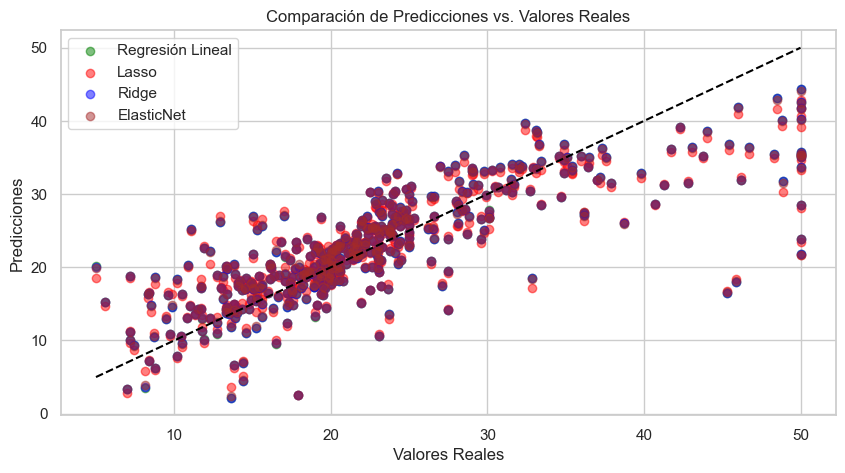

In [253]:
# Graficar predicciones vs. valores reales
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lr.predict(X_train_scaled), label='Regresión Lineal', color='green', alpha=0.5)
plt.scatter(y_train, lasso.predict(X_train_scaled), label='Lasso', color='red', alpha=0.5)
plt.scatter(y_train, ridge.predict(X_train_scaled), label='Ridge', color='blue', alpha=0.5)
plt.scatter(y_train, elasticnet.predict(X_train_scaled), label='ElasticNet', color='brown', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


# Gradientes descendentes

## Gradiente descendente estocástico (SGD)

In [254]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar el término de sesgo (bias) a las matrices de entrada
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Inicializar los pesos de forma aleatoria
    W = np.random.randn(m + 1, 1)

    train_errors = []
    test_errors = []

    # Convertir y_train y y_test a numpy.ndarray
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation].reshape(-1, 1)  # Asegurarse de que y_train sea un vector columna

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j].reshape(1, -1)
            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse[0])

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test  # Asegurarse de que y_test sea un vector columna
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T
            W = W - (lr * gradient)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W


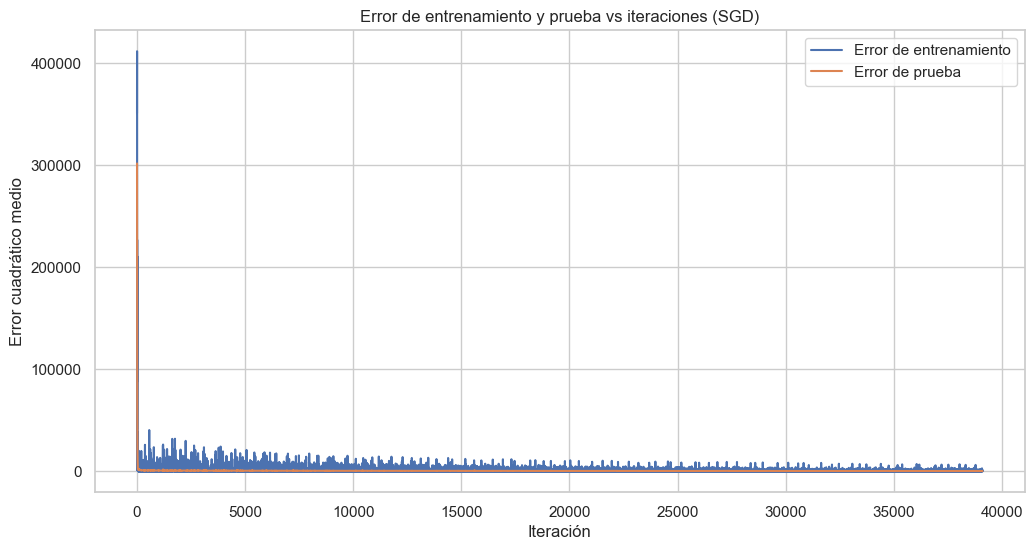

array([[-0.48562502],
       [-0.79890277],
       [ 0.06822181],
       [-0.58179723],
       [ 0.51704527],
       [-0.93615754],
       [-0.67919395],
       [-0.03766331],
       [ 1.92670112],
       [-0.36927879],
       [ 0.03937918],
       [ 0.3197627 ],
       [ 0.00471094],
       [ 0.93939655]])

In [257]:
stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.0000001, epochs=92)

### Observaciones del Gráfico de MSE en Stochastic Gradient Descent (SGD)

1. **Curva de error de entrenamiento y prueba**:
   - Inicialmente, el *error cuadrático medio (MSE)* es alto tanto para los datos de entrenamiento como para los de prueba.
   - Sin embargo, el error desciende rápidamente en las primeras iteraciones (aproximadamente dentro de las primeras 2000 iteraciones).
   - Después de esta rápida caída inicial, tanto el error de entrenamiento como el error de prueba se estabilizan cerca de 0, manteniéndose prácticamente planos durante el resto de las iteraciones (hasta las 30,000).

2. **Posible explicación del comportamiento**:
   - Este comportamiento indica que el modelo ha *convergido correctamente* y está ajustando tanto los datos de entrenamiento como los de prueba de manera adecuada.
   - La rápida disminución del error en las primeras iteraciones es característica del *SGD*, donde, con una tasa de aprendizaje adecuada, el modelo ajusta sus pesos rápidamente hacia un mínimo local o global.
   - La estabilización del error en valores muy bajos para ambas curvas es un buen indicio de que el modelo está bien generalizado y no está sobreajustando, ya que los errores de prueba y entrenamiento son similares y bajos.

3. **Interpretación general**:
   - Este gráfico sugiere que el modelo está funcionando bien y que el proceso de aprendizaje está controlado, sin problemas de *divergencia*.


## Gradiente descendente (GD o Batch)

In [255]:
def gradient_descent(X_train, y_train, X_val, y_val, lr, epochs):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    """
    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características

    o = X_val.shape[0]  # Número de ejemplos de validación

    # Poner columna de unos a las matrices X para el término de sesgo (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Convertir y_train y y_val a arrays de NumPy y asegurarse de que sean vectores columna
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_val = y_val.to_numpy().reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de validación en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de validación
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

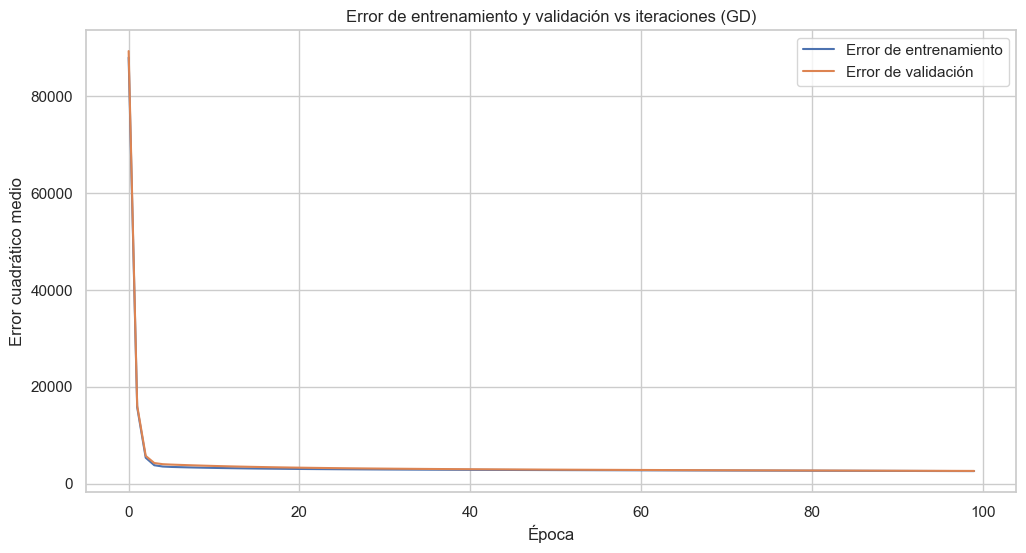

array([[ 1.33041204],
       [ 0.07644919],
       [-1.31434983],
       [-0.09573022],
       [-0.1630531 ],
       [ 1.18659933],
       [-0.64795855],
       [-1.99348055],
       [-0.3338689 ],
       [ 0.03207667],
       [ 0.24262296],
       [-1.16340537],
       [ 0.27669138],
       [-0.12049422]])

In [258]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=100)


### Observaciones del Gradiente Descendente (Batch GD)

En este gráfico, observamos cómo el error de entrenamiento y el error de validación disminuyen a lo largo de las épocas. 

- El error de ambos (entrenamiento y validación) decrece continuamente conforme el modelo ajusta sus parámetros, lo cual es una señal de que el gradiente descendente está funcionando correctamente.
- A medida que las épocas avanzan, las curvas comienzan a estabilizarse, lo que indica que el modelo está convergiendo a un mínimo local del error.

**Conclusión:**

Este comportamiento es típico de un modelo bien entrenado, donde el error de entrenamiento disminuye de manera constante, y el error de validación también mejora, lo que sugiere que el modelo no está sobreajustando los datos.

## Gradiente Descendente Mini-Batch GD

In [256]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs, batch_size):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))


    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

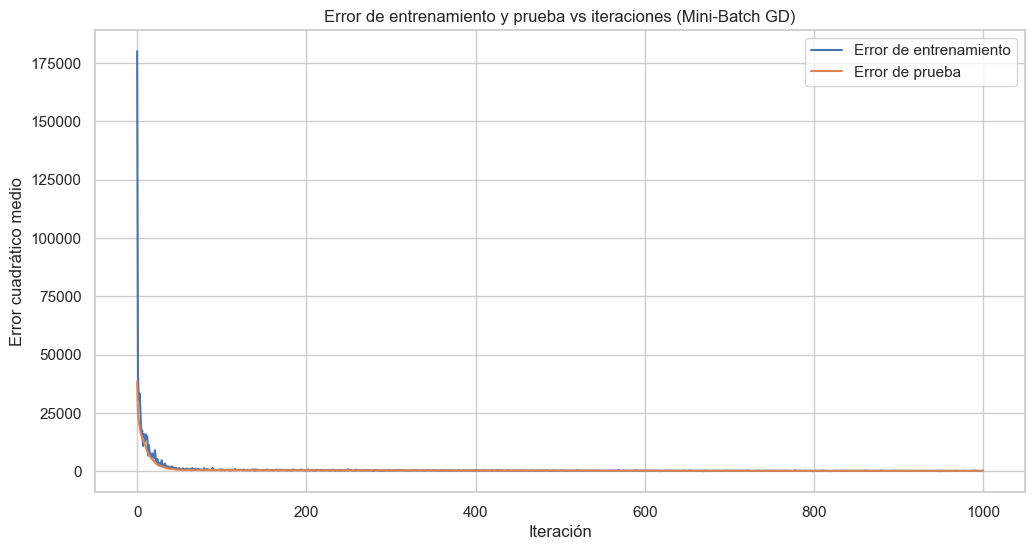

array([[-2.03669956],
       [-0.19390172],
       [ 0.31489086],
       [ 2.27429333],
       [-0.28125022],
       [-0.08145336],
       [ 0.91286512],
       [-0.29447254],
       [-1.05773512],
       [-0.44949172],
       [-0.01644534],
       [ 1.4461281 ],
       [ 0.0123355 ],
       [-0.45017435]])

In [260]:
mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=100, batch_size=40)


### Observaciones del Gráfico Mini-Batch Gradient Descent

- **Disminución rápida del error inicial**: 
  - Al comienzo, el error (tanto en el entrenamiento como en la prueba) es bastante alto, pero disminuye rápidamente en las primeras iteraciones. 
  - Esto indica que el modelo está aprendiendo rápidamente los patrones principales del conjunto de datos.

- **Estabilización del error**: 
  - Después de las primeras 100-200 iteraciones, el error se estabiliza y alcanza un nivel bajo y constante. 
  - Esto es típico de un modelo que ha alcanzado una convergencia razonable.

- **Pequeñas fluctuaciones**: 
  - Se observan pequeñas fluctuaciones en el error a lo largo de las iteraciones, especialmente en las etapas finales. 
  - Esto es característico del Mini-Batch Gradient Descent, ya que cada mini-lote introduce algo de ruido en la estimación del gradiente.
  - Sin embargo, las fluctuaciones no son significativas y permanecen alrededor de un valor constante.

- **Error de entrenamiento vs. error de prueba**: 
  - Los errores de entrenamiento y de prueba son casi idénticos, lo que sugiere que el modelo no está sobreajustando a los datos de entrenamiento. 
  - Esto es un buen signo de generalización.




-------------------------------------------------------------------------------------------------------------------------------------------------


# Análisis de Datos y Modelado

## 1. Análisis Descriptivo de los Datos

- **Análisis de datos faltantes**:
  - Identifica si hay valores faltantes en tu dataset y decide cómo manejarlos (por ejemplo, imputación, eliminación).

- **Visualización de datos**:
  - Genera histogramas, diagramas de dispersión (scatterplots), y diagramas sde caja (boxplots) para comprender mejor la distribución de cada variable.

- **Codificación de variables categóricas**:
  - Si alguna variable es categórica, conviértela en variables numéricas (usualmente se utiliza One-Hot Encoding).

- **Matriz de correlación**:
  - Calcula la correlación entre variables para ver cómo se relacionan entre sí.

- **Estandarización o escalado de datos**:
  - Aplica técnicas de escalado como la normalización o estandarización si es necesario.

## 2. División de los Datos en Entrenamiento y Prueba

- Realiza una división de los datos en conjuntos de entrenamiento y prueba (usualmente 70% entrenamiento y 30% prueba).

## 3. Implementación de Modelos de Regresión

- **Regresión Lineal Múltiple**:
  - Usa `LinearRegression` de scikit-learn.

- **Gradiente Descendiente**:
  - Implementa regresión utilizando métodos de gradiente descendiente y analiza si hay cambios significativos.

- **Métodos de Regularización**:
  - Aplica Lasso, Ridge, y Elastic Net para ver cómo afectan los resultados.

## 4. Evaluación de Modelos

- Calcula métricas como R² Score, MSE, RMSE, MAE, MAPE tanto en el conjunto de entrenamiento como en el de prueba.

- Compara el rendimiento entre los distintos modelos.

## 5. Optimización de Hiperparámetros

- Varía los hiperparámetros en los métodos de gradiente descendiente y regularización, observa cómo cambian los resultados.

## 6. Comparación de Modelos

- Realiza una comparación final de todos los modelos para determinar cuál es el mejor basado en las métricas adecuadas.
